In [4]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from pandas import DataFrame, Series
from datetime import datetime
import random
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as stats
import matplotlib.font_manager as fm
import scipy.stats as stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import f1_score
from xgboost import XGBClassifier
from google.colab import drive

drive.mount('/content/drive')

path = '/content/drive/MyDrive/test/'
df = pd.read_csv(path + "train.csv")
test = pd.read_csv(path + 'test.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
df.replace('Y',1, inplace = True)
df.replace('N',0, inplace = True)

test.replace('Y',1, inplace = True)
test.replace('N',0, inplace = True)

test = test.fillna(df.mean())

In [6]:
df.loc[df['SMK_STAT'] == 2, 'SMK_STAT'] = 0.5

In [7]:
def Interpolation_num(forthis, uselist) :
  use_df = df[uselist + [forthis] + ['ID']]

  null_indices = use_df[use_df[forthis].isnull()].index.tolist()
  notnull_indices = set(list(range(len(df)))) - set(null_indices)
  has_null = use_df.loc[null_indices]
  hasnot_null = use_df.loc[notnull_indices]
  has_null = has_null.dropna(subset = uselist)

  hasnot_null = hasnot_null.dropna(axis = 0)

  x = hasnot_null[uselist]
  y = hasnot_null[[forthis]]

  x2 = has_null[uselist]
  y2 = hasnot_null[[forthis]]

  mlr = LinearRegression()
  mlr.fit(x, y)

  y_predict = mlr.predict(x2)

  y_predict_int = []
  for i in range(len(y_predict)) :
    y_predict_int.append(y_predict[i][0])
    
  y_predict = y_predict_int

  ID_array = list(has_null['ID'])
  putthis = pd.DataFrame({'ID' : ID_array,
                        forthis : y_predict})

  for i in range(len(ID_array)) :
    index = ID_array[i]-1
    predict = y_predict[i]
    df.at[index, forthis] = predict

In [8]:
def Interpolation_cate(forthis, uselist) :
  use_df = df[uselist + [forthis] + ['ID']]

  null_indices = use_df[use_df[forthis].isnull()].index.tolist()
  notnull_indices = set(list(range(len(df)))) - set(null_indices)
  has_null = use_df.loc[null_indices]
  hasnot_null = use_df.loc[notnull_indices]
  has_null = has_null.dropna(subset = uselist)

  hasnot_null = hasnot_null.dropna(axis = 0)

  x = hasnot_null[uselist]
  y = hasnot_null[[forthis]]

  x2 = has_null[uselist]
  y2 = hasnot_null[[forthis]]

  mlr = LinearRegression()
  mlr.fit(x, y)

  y_predict = mlr.predict(x2)

  y_predict_int = []
  for i in range(len(y_predict)) :
    y_predict_int.append(y_predict[i][0])
    
  y_predict = y_predict_int

  ID_array = list(has_null['ID'])
  putthis = pd.DataFrame({'ID' : ID_array,
                        forthis : y_predict})

  for i in range(len(ID_array)) :
    index = ID_array[i]-1
    predict = y_predict[i]
    df.at[index, forthis] = int(round(predict))

In [9]:
# 음의 상관 고려 안 함 (0.691)

use_feature_cate = [['OLIG_PROTE', ['BLDS', 'CREATININE', 'BP_HIGH']],
                    ['CRS_YN', ['HEIGHT', 'WEIGHT', 'HMG']],
                    ['TTR_YN', ['CRS_YN', 'HMG', 'WEIGHT']]]
use_feature_num = [['WAIST', ['WEIGHT', 'HMG', 'BP_HIGH']],
                   ['BP_HIGH', ['WAIST', 'AGE', 'WEIGHT']],
                   ['BP_LWST', ['BP_HIGH', 'WEIGHT', 'WAIST']],
                   ['BLDS', ['WAIST', 'AGE', 'BP_HIGH']],
                   ['HMG', ['HEIGHT', 'WEIGHT', 'WAIST']],
                   ['CREATININE', ['HEIGHT', 'WEIGHT', 'HMG']],
                   ['SGOT_AST', ['WAIST', 'HMG', 'WEIGHT']],
                   ['SGOT_ALT', ['SGOT_AST', 'WEIGHT', 'WAIST']],
                   ['GAMMA_GTP', ['SGOT_ALT', 'SGOT_AST', 'HMG']],
                   ['TOT_CHOLE', ['HMG', 'BP_LWST', 'GAMMA_GTP']],
                   ['TRIGLYCERIDE', ['GAMMA_GTP', 'WAIST', 'WEIGHT']],
                   ['HDL_CHOLE', ['SEX', 'TOT_CHOLE', 'DRK_YN']],
                   ['LDL_CHOLE', ['TOT_CHOLE', 'HMG', 'BP_LWST']]]

In [10]:
for i in range(len(use_feature_num)) :
  forthis = use_feature_num[i][0]
  uselist = use_feature_num[i][1]
  Interpolation_num(forthis, uselist)

for i in range(len(use_feature_cate)) :
  forthis = use_feature_cate[i][0]
  uselist = use_feature_cate[i][1]
  Interpolation_cate(forthis, uselist)

In [11]:
df = df.drop(['SIGHT_LEFT', 'SIGHT_RIGHT', 'HEAR_LEFT', 'HEAR_RIGHT'], axis = 1)
test = test.drop(['SIGHT_LEFT', 'SIGHT_RIGHT', 'HEAR_LEFT', 'HEAR_RIGHT'], axis = 1)
df = df.dropna(axis = 0) 

idx = df[(df['OLIG_PROTE'] < 1) | (df['OLIG_PROTE'] > 6 )].index
df = df.drop(idx)

idx = df[(df['CRS_YN'] < 0) | (df['CRS_YN'] > 1)].index
df = df.drop(idx)

idx = df[(df['TTR_YN'] < 0) | (df['TTR_YN'] > 1)].index
df = df.drop(idx)

df = df.astype({'OLIG_PROTE' : int,
                'CRS_YN' : int,
                'TTR_YN' : int})

indexfordelete = df[df['SMK_STAT'] == 0.5].index
df = df.drop(indexfordelete) 

test = test.astype({'OLIG_PROTE' : int,
                'CRS_YN' : int,
                'TTR_YN' : int})

In [12]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 24 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   ID                 100000 non-null  int64  
 1   SEX                100000 non-null  int64  
 2   AGE                100000 non-null  int64  
 3   SIDO               100000 non-null  int64  
 4   HEIGHT             100000 non-null  int64  
 5   WEIGHT             100000 non-null  int64  
 6   WAIST              100000 non-null  float64
 7   BP_HIGH            100000 non-null  float64
 8   BP_LWST            100000 non-null  float64
 9   BLDS               100000 non-null  float64
 10  TOT_CHOLE          100000 non-null  float64
 11  TRIGLYCERIDE       100000 non-null  float64
 12  HDL_CHOLE          100000 non-null  float64
 13  LDL_CHOLE          100000 non-null  float64
 14  HMG                100000 non-null  float64
 15  OLIG_PROTE         100000 non-null  int64  
 16  CRE

In [13]:
df.to_csv('/content/drive/My Drive/test/train2.csv', index = False)
test.to_csv('/content/drive/My Drive/test/test2.csv', index = False)

In [14]:
df = pd.read_csv(path + "train2.csv")
test = pd.read_csv(path + "test2.csv")

In [15]:
df.info()
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80122 entries, 0 to 80121
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ID                 80122 non-null  int64  
 1   SEX                80122 non-null  int64  
 2   AGE                80122 non-null  int64  
 3   SIDO               80122 non-null  int64  
 4   HEIGHT             80122 non-null  int64  
 5   WEIGHT             80122 non-null  int64  
 6   WAIST              80122 non-null  float64
 7   BP_HIGH            80122 non-null  float64
 8   BP_LWST            80122 non-null  float64
 9   BLDS               80122 non-null  float64
 10  TOT_CHOLE          80122 non-null  float64
 11  TRIGLYCERIDE       80122 non-null  float64
 12  HDL_CHOLE          80122 non-null  float64
 13  LDL_CHOLE          80122 non-null  float64
 14  HMG                80122 non-null  float64
 15  OLIG_PROTE         80122 non-null  int64  
 16  CREATININE         801

In [16]:
train_col_categorical = ['SEX','OLIG_PROTE','DRK_YN','HCHK_OE_INSPEC_YN','SMK_STAT']
train_cate = df[train_col_categorical].astype('category') #윗줄의 해당 변수들을 범주형 타입으로 변경
train_num = df.drop(train_col_categorical,axis=1).astype('float')
train_total = pd.concat([train_cate,train_num],axis=1)

test_col_categorical = ['SEX','OLIG_PROTE','DRK_YN','HCHK_OE_INSPEC_YN']
test_cate = df[test_col_categorical].astype('category')
test_num = df.drop(test_col_categorical,axis=1).astype('float')
test_total = pd.concat([test_cate,test_num],axis=1)

In [17]:
predict_col_categorical = ['SEX','OLIG_PROTE','DRK_YN','HCHK_OE_INSPEC_YN']
predict_cate = test[predict_col_categorical].astype('category')
predict_num = test.drop(predict_col_categorical,axis=1).astype('float')
predict_total = pd.concat([predict_cate,predict_num],axis=1)

In [18]:
# categorical feature -> one hot encoding 진행

# 성별을 예로 들면 데이터에서 성별이 0(여성),1(남성) 이렇게 구분되어 있다고 가정할 때 이 경우 남성이 여성보다 1만큼 큰 개념이 아니므로, 
# 여성과 남성에 해당하는 변수를 하나씩 만들어서 여성인 경우 여성변수에 1, 남성 변수에 0 / 남성인 경우 여성 변수에 0, 남성 변수에 1 을 할당한 것
encoder = OneHotEncoder(sparse=False)   #OneHotEncoding 하게 해주는 인코더 정의 부분 
sex_onehot = encoder.fit_transform(train_total[['SEX']])   #fit_transform 통해서 trainsetdml sex 변수를 onehotencoding 시킨 것
print("SEX category : ",encoder.categories_[0],"\n")
temp = pd.DataFrame(sex_onehot, columns=['sex_' + str(col) for col in encoder.categories_[0]]) # 위에서 onehotencoding 시킨 데이터가 array 형태이므로
#이를 dataframe 형식으로 바꾸고 이 때 새로 만들어진 변수명을 그냥 temp로 지정함 (그냥 보기 좋으려고)
train_total = pd.concat([train_total.drop(columns=['SEX']),temp], axis=1)  #더이상 쓸모 없어진 원래 sex 변수를 제거한 다음 셋째줄에서 만든 dataframe과 합치는 과정 
sex_onehot_test = encoder.transform(test_total[['SEX']]) #위에서 설명하 과정을 test에도 똑같이 함 그리고 밑은 계속 변수만 바뀌고 코드 같음 반복
temp = pd.DataFrame(sex_onehot_test, columns=['sex_' + str(col) for col in encoder.categories_[0]])
test_total = pd.concat([test_total.drop(columns=['SEX']),temp], axis=1)

encoder = OneHotEncoder(sparse=False)
olig_prote_onehot = encoder.fit_transform(train_total[['OLIG_PROTE']])
print("OLIG_PROTE category : ",encoder.categories_[0],"\n")
temp = pd.DataFrame(olig_prote_onehot, columns=['olig_prote_' + str(col) for col in encoder.categories_[0]])
train_total = pd.concat([train_total.drop(columns=['OLIG_PROTE']),temp], axis=1)
olig_prote_onehot_test = encoder.transform(test_total[['OLIG_PROTE']])
temp = pd.DataFrame(olig_prote_onehot_test, columns=['olig_prote_' + str(col) for col in encoder.categories_[0]])
test_total = pd.concat([test_total.drop(columns=['OLIG_PROTE']),temp], axis=1)

encoder = OneHotEncoder(sparse=False)
drk_yn_onehot = encoder.fit_transform(train_total[['DRK_YN']])
print("DRK_YN category : ",encoder.categories_[0],"\n")
temp = pd.DataFrame(drk_yn_onehot, columns=['drk_yn_' + str(col) for col in encoder.categories_[0]])
train_total = pd.concat([train_total.drop(columns=['DRK_YN']),temp], axis=1)
drk_yn_onehot_test = encoder.transform(test_total[['DRK_YN']])
temp = pd.DataFrame(drk_yn_onehot_test, columns=['drk_yn_' + str(col) for col in encoder.categories_[0]])
test_total = pd.concat([test_total.drop(columns=['DRK_YN']),temp], axis=1)

encoder = OneHotEncoder(sparse=False)
hchk_oe_inspec_yn_onehot = encoder.fit_transform(train_total[['HCHK_OE_INSPEC_YN']])
print("HCHK_OE_INSPEC_YN category : ",encoder.categories_[0],"\n")
temp = pd.DataFrame(hchk_oe_inspec_yn_onehot, columns=['hchk_oe_inspec_yn_' + str(col) for col in encoder.categories_[0]])
train_total = pd.concat([train_total.drop(columns=['HCHK_OE_INSPEC_YN']),temp], axis=1)
hchk_oe_inspec_yn_onehot_test = encoder.transform(test_total[['HCHK_OE_INSPEC_YN']])
temp = pd.DataFrame(hchk_oe_inspec_yn_onehot_test, columns=['hchk_oe_inspec_yn_' + str(col) for col in encoder.categories_[0]])
test_total = pd.concat([test_total.drop(columns=['HCHK_OE_INSPEC_YN']),temp], axis=1)

# ID는 필요 없으므로 제거
train_id = train_total['ID']
train_total = train_total.drop(['ID'], axis=1)
test_id = test_total['ID']
test_total = test_total.drop(['ID'], axis=1)

SEX category :  [1 2] 

OLIG_PROTE category :  [1 2 3 4 5 6] 

DRK_YN category :  [0 1] 

HCHK_OE_INSPEC_YN category :  [0 1] 



In [19]:
encoder2 = OneHotEncoder(sparse=False)
sex_onehot = encoder2.fit_transform(predict_total[['SEX']])
print("SEX category : ",encoder2.categories_[0],"\n")
temp = pd.DataFrame(sex_onehot, columns=['sex_' + str(col) for col in encoder2.categories_[0]])
predict_total = pd.concat([predict_total.drop(columns=['SEX']),temp], axis=1)

encoder2 = OneHotEncoder(sparse=False)
olig_prote_onehot = encoder2.fit_transform(predict_total[['OLIG_PROTE']])
print("OLIG_PROTE category : ",encoder2.categories_[0],"\n")
temp = pd.DataFrame(olig_prote_onehot, columns=['olig_prote_' + str(col) for col in encoder2.categories_[0]])
predict_total = pd.concat([predict_total.drop(columns=['OLIG_PROTE']),temp], axis=1)

encoder2 = OneHotEncoder(sparse=False)
drk_yn_onehot = encoder2.fit_transform(predict_total[['DRK_YN']])
print("DRK_YN category : ",encoder2.categories_[0],"\n")
temp = pd.DataFrame(drk_yn_onehot, columns=['drk_yn_' + str(col) for col in encoder2.categories_[0]])
predict_total = pd.concat([predict_total.drop(columns=['DRK_YN']),temp], axis=1)

encoder2 = OneHotEncoder(sparse=False)
hchk_oe_inspec_yn_onehot = encoder2.fit_transform(predict_total[['HCHK_OE_INSPEC_YN']])
print("HCHK_OE_INSPEC_YN category : ",encoder2.categories_[0],"\n")
temp = pd.DataFrame(hchk_oe_inspec_yn_onehot, columns=['hchk_oe_inspec_yn_' + str(col) for col in encoder2.categories_[0]])
predict_total = pd.concat([predict_total.drop(columns=['HCHK_OE_INSPEC_YN']),temp], axis=1)

# # ID는 필요 없으므로 제거
predict_id = predict_total['ID']
predict_total = predict_total.drop(['ID'], axis=1)

SEX category :  [1 2] 

OLIG_PROTE category :  [1 2 3 4 5 6] 

DRK_YN category :  [0 1] 

HCHK_OE_INSPEC_YN category :  [0 1] 



In [20]:
# train/test split
from sklearn.model_selection import train_test_split

X = train_total.drop(['SMK_STAT'],axis=1)     #x에 변수들을 넣어서 y를 끌어내고 싶은거니까 (흡연여부) 흡연여부가 x에 들어가면 안됨
y = train_total['SMK_STAT']

x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.1,random_state=123)

print(f"train_x size : {x_train.shape}")
print(f"train_y size : {y_train.shape}")
print(f"x_test size : {x_test.shape}")
print(f"y_test size : {y_test.shape}")

train_x size : (72109, 31)
train_y size : (72109,)
x_test size : (8013, 31)
y_test size : (8013,)


In [21]:
# model 학습 (xgboost, randomforest)

# cross_validation을 통한 하이퍼 파라미터 최적화 진행(Kfold with K=5)
n = range(10,100,10)

rf_scores = []
xg_scores = []
for k in n:
    print(f"Current tree : {k}")
    rf_model = RandomForestClassifier(n_estimators = k, n_jobs=-1) 
    xg_model = XGBClassifier(n_estimators = k, n_jobs=-1) # 이줄까지는 알고리즘 정의 트리 k개를 사용하여 모델 정의하겠단 뜻
    # 이 밑 코드는 kfold crossvalidation 부분 train set 통해서 진행 측정 지표는 f1 score cv = 5 는 
    # 매 학습시 5분할하여 5-fold crossvaliation 하는 것  그 결과 지표들을 각각 rf_score, xg_score 에 저장
    rf_scores.append(cross_val_score(rf_model, x_train, y_train, scoring='f1', cv=5, n_jobs=-1).mean())
    xg_scores.append(cross_val_score(xg_model, x_train, y_train, scoring='f1', cv=5, n_jobs=-1).mean())
    print('finished')

Current tree : 10
finished
Current tree : 20
finished
Current tree : 30
finished
Current tree : 40
finished
Current tree : 50
finished
Current tree : 60
finished
Current tree : 70
finished
Current tree : 80
finished
Current tree : 90
finished


<Cross validation result>
Random forest val_score : [0.5950392239298216, 0.6284818392125434, 0.6416685923046686, 0.648261163764951, 0.6539720765315542, 0.6571074942532631, 0.6597349447508558, 0.6574935235249367, 0.6619616438250289]
Xgboost val_score : [0.6488277722737884, 0.658898527540942, 0.6681773256188419, 0.6707655350319227, 0.6723872187413178, 0.6728613580134799, 0.6736634231264561, 0.6743840556638966, 0.6756135293415171]


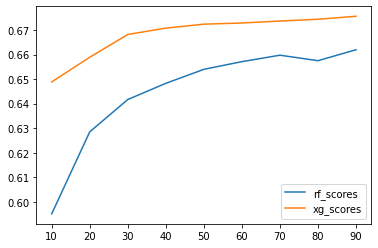

In [22]:
print("<Cross validation result>")
print(f"Random forest val_score : {rf_scores}")
print(f"Xgboost val_score : {xg_scores}")

plt.plot(range(10,100,10), rf_scores)
plt.plot(range(10,100,10), xg_scores)
plt.legend(['rf_scores', 'xg_scores'])
plt.show()

In [23]:
# 최적의 hyper-param으로 재학습
# xgboost의 성능이 비교적 높은 것 같아서 이 모델을 사용하기로 결정
xg_model = XGBClassifier(n_estimators=90, n_jobs=-1)
xg_model = xg_model.fit(x_train, y_train)

# test set 적용 결과
print("Test F1score of xgboost : ",round(f1_score(y_test,xg_model.predict(x_test)),3))

Test F1score of xgboost :  0.678


In [24]:
predict_total.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 31 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   AGE                  100000 non-null  float64
 1   SIDO                 100000 non-null  float64
 2   HEIGHT               100000 non-null  float64
 3   WEIGHT               100000 non-null  float64
 4   WAIST                100000 non-null  float64
 5   BP_HIGH              100000 non-null  float64
 6   BP_LWST              100000 non-null  float64
 7   BLDS                 100000 non-null  float64
 8   TOT_CHOLE            100000 non-null  float64
 9   TRIGLYCERIDE         100000 non-null  float64
 10  HDL_CHOLE            100000 non-null  float64
 11  LDL_CHOLE            100000 non-null  float64
 12  HMG                  100000 non-null  float64
 13  CREATININE           100000 non-null  float64
 14  SGOT_AST             100000 non-null  float64
 15  SGOT_ALT          

In [25]:
predict_total = predict_total.loc[:,~predict_total.columns.duplicated()]
predict_total_predict = pd.DataFrame(xg_model.predict(predict_total))
predict_total_predict.columns = ['SMK_STAT']
predict_total_predict.info()
predict_result = pd.concat([predict_id, predict_total, predict_total_predict],axis=1)
predict_result

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 1 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   SMK_STAT  100000 non-null  float64
dtypes: float64(1)
memory usage: 781.4 KB


,ID,AGE,SIDO,HEIGHT,WEIGHT,WAIST,BP_HIGH,BP_LWST,BLDS,TOT_CHOLE,...,olig_prote_2,olig_prote_3,olig_prote_4,olig_prote_5,olig_prote_6,drk_yn_0,drk_yn_1,hchk_oe_inspec_yn_0,hchk_oe_inspec_yn_1,SMK_STAT
0,100001.0,40.0,41.0,155.0,45.0,65.0,125.0,80.0,87.0,196.108728,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,100002.0,65.0,44.0,155.0,70.0,91.0,139.0,75.0,122.0,196.108728,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,100003.0,60.0,11.0,155.0,50.0,77.5,130.0,86.0,91.0,196.108728,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,100004.0,40.0,30.0,165.0,65.0,79.0,106.0,73.0,94.0,196.108728,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
4,100005.0,25.0,41.0,160.0,50.0,67.0,109.0,62.0,83.0,196.108728,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,199996.0,30.0,47.0,175.0,65.0,82.0,132.0,78.0,91.0,221.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
99996,199997.0,55.0,41.0,160.0,75.0,89.0,132.0,82.0,113.0,323.000000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
99997,199998.0,45.0,41.0,150.0,55.0,66.0,136.0,84.0,105.0,196.108728,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
99998,199999.0,50.0,41.0,170.0,70.0,82.4,138.0,86.0,97.0,196.108728,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0


In [26]:
predict_result["SMK_STAT"].to_csv('/content/drive/My Drive/test/result.csv', index = False)